# Smart Charging Using Reinforcement Learning

In [1]:
import numpy as np
import math
import tqdm
from collections import defaultdict

import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.registration import register

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

## Learning Resources and environments we can use

- (Alternative: Simpy)

- OpenAI gym
    - [Official Gymnasium GitHub](https://github.com/Farama-Foundation/Gymnasium)
    - [Gymnasium Docu](https://gymnasium.farama.org/)
        - [Creating a Gymnasium Environment](https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/)
        - [Lunar Lander example](https://gymnasium.farama.org/environments/box2d/lunar_lander/)
    - [OpenAI Learning platform for Gymnasium](https://spinningup.openai.com/en/latest/index.html)
        - [OpenAI Algorithms](https://spinningup.openai.com/en/latest/algorithms/ddpg.html#background)

- [Here is a good resource for all deep-RL algorithms](https://github.com/p-christ/Deep-Reinforcement-Learning-Algorithms-with-PyTorch/blob/master/README.md) (look into the results folder)

## Plotting functions

In [2]:
def create_grids(q_values):
    """Create value and policy grid given q_values from an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for observation, action_values in q_values.items():
        state_value[observation] = float(np.max(action_values))
        policy[observation] = int(np.argmax(action_values))

    timstep, battery_level = np.meshgrid(
        np.arange(1, 9),
        np.arange(0, 200, 7),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1])],
        axis=2,
        arr=np.dstack([timstep, battery_level]),
    )
    value_grid = battery_level, timstep, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1])],
        axis=2,
        arr=np.dstack([timstep, battery_level]),
    )
    return value_grid, policy_grid

In [3]:
def create_plots(value_grid, policy_grid):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    timstep, battery_level, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    #fig.suptitle(fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        timstep,
        battery_level,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(0, 200, 21), range(0, 200, 21))
    plt.yticks(range(1, 9), range(1, 9))
    ax1.set_title(f"State values: ")
    ax1.set_xlabel("Battery Level")
    ax1.set_ylabel("Time left")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    cmap = ["grey", "red", "orange", "yellow", "green"]
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap=cmap, cbar=False)
    ax2.set_title(f"Policy: ")
    ax2.set_xlabel("Time left")
    ax2.set_ylabel("Battery Level")
    ax2.set_xticklabels(range(1, 9))
    ax2.set_yticklabels(range(0, 200, 14))

    # add a legend
    legend_elements = [
        Patch(facecolor="grey", edgecolor="black", label="-1"),
        Patch(facecolor="red", edgecolor="black", label="0"),
        Patch(facecolor="orange", edgecolor="black", label="7"),
        Patch(facecolor="yellow", edgecolor="black", label="14"),
        Patch(facecolor="green", edgecolor="black", label="21"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig

In [4]:
def plot_training_performance(env, agent):
    rolling_length = 500
    fig, axs = plt.subplots(ncols=2, figsize=(16, 5))
    axs[0].set_title("Episode rewards")
    # compute and assign a rolling average of the data to provide a smoother graph
    reward_moving_average = (
        np.convolve(
            np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
        )
        / rolling_length
    )
    axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
    axs[1].set_title("Training Error")
    training_error_moving_average = (
        np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
        / rolling_length
    )
    axs[1].plot(range(len(training_error_moving_average)), training_error_moving_average)
    plt.tight_layout()
    plt.show()

## Finite Markov Decision Process (MDP)

A **Markov Process** (or Markov Chain) is a tuple ⟨S, A, P, R⟩
- S is a set of **states**
    - States: time, battery_level, (charging_rate), (atHome)
        - time: Discrete 15-minute intervals from 2 p.m. to 4 p.m. (count down?)
        - battery_level: The current battery level (from 0 kW to battery capacity kW)
        - charging_rate: The current charging rate (between 0 kW and the highest rate (e.g., 22 kW (We need to choose)))
        - atHome: Indicator if the agent is at home or departured
- A is a set of **actions**
    - Actions: {zero: 0 kW, low: 7 kW, medium: 14 kW, high: 21 kW}
        - The actions are the discrete charging rates that the agent can choose at each discrete timestep.
- P is a state **transition probability** function, (P<sup>a</sup><sub>SS'</sub> = P[S<sub>t</sub> = s'| S<sub>t-1</sub> = s, A<sub>t-1</sub> = a])
    - Transition Probability:
- R is a **reward** function of states and actions
    - Reward:
        - Running out of energy: eg. -1000
        - Charging costs: i.e.,  charging cost (t,p) = ∑<sub>𝑡∈𝑇</sub> 𝛼<sub>𝑡</sub> 𝑒<sup>𝑝</sup>), where 𝛼<sub>𝑡</sub> is the time coefficient and p is the charging rate.
    - Reward function:
    
**Goal:** Finding the optimal policies (which action to take in different states)  
**Trade-off:** The agent’s goal is to avoid running out of energy (you should consider a very high penalty for running out of energy) and to minimize the recharging cost.

**Further Assumptions:**
- Battery capacity: 
- Energy demand function: stochastic value following a normal distribution
    - Parameters: 𝜇= 30 kWh, 𝜎 = 5 kWh (Note: must be generated exactly when the driver wants to leave.)

In [5]:
NUMBER_OF_TIMESTEPS = 8
MEAN = 40
STANDARD_DEVIATION = 20

class SmartChargingEnv(gym.Env):

    def __init__(self, battery_capacity=200, time_coefficient=1):
        self.time_limit = NUMBER_OF_TIMESTEPS  # The number of timesteps (e.g. 2pm-4pm := 8 timesteps)
        self.battery_capacity = battery_capacity  # The battery capacity
        self.time_coefficient = time_coefficient
        self.penalty_out_of_energy = -1000
        self.max_charging_rate = 21
        
        self.observation_space = spaces.Tuple([spaces.Discrete(self.time_limit + 1, start=0), spaces.Discrete(battery_capacity + 1, start=0)])

        # We have 4 actions, corresponding to "zero", "low", "medium", "high"
        self.action_space = spaces.Discrete(4)

        """
        The following dictionary maps abstract actions from `self.action_space` to
        the charging values.
        """
        charging_rates = np.linspace(0, self.max_charging_rate, 4)
        self._action_to_charging_rates = {
            0: charging_rates[0],
            1: charging_rates[1],
            2: charging_rates[2],
            3: charging_rates[3],
        }


    def _get_obs(self):
        return (self._current_time, self._agent_battery_level)

    def _get_info(self):
        return {
            "remaining_capacity": self.battery_capacity - self._agent_battery_level
        }
            

    def reset(self, seed = None, options = None):
        self._current_time = self.time_limit

        self._agent_battery_level = 0

        observation = self._get_obs()
        info = self._get_info()

        return observation, info

    def step(self, action):
        # Map the action to the charging rate
        charging_rate = self._action_to_charging_rates[action]
        
        # Update baterry level and time
        self._agent_battery_level = np.clip(
            self._agent_battery_level + charging_rate, 0, self.battery_capacity
        )
        self._current_time -= 1
        # An episode is done if the time limit is reached
        terminated = (0 == self._current_time)
        
        # calculate reward
        reward = 0
        if terminated:
            energy_demand = np.random.normal(MEAN, STANDARD_DEVIATION)
            reward = (self._agent_battery_level < energy_demand) * self.penalty_out_of_energy
        reward -= self._get_charging_cost(charging_rate)
        
        observation = self._get_obs()
        info = self._get_info()
        
        return observation, reward, terminated, False, info
    
    def _get_charging_cost(self, _charging_rate):
        return self.time_coefficient * math.exp(_charging_rate / self.max_charging_rate)

    def render(self):
        pass
        
    def close(self):
        pass

## First RL-model: SARSA (TD control problem, On-Policy)

In [6]:
class SarsaAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, observation: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[observation]))

    def update(
        self,
        observation: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_observation: tuple[int, int, bool],
        next_action: int,
    ):
        """Updates the Q-value of an action."""
        target_q_value = (not terminated) * self.q_values[next_observation][next_action]
        temporal_difference = (
            reward + self.discount_factor * target_q_value - self.q_values[observation][action]
        )

        self.q_values[observation][action] = (
            self.q_values[observation][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [7]:
def run_sarsa_learning(env, sarsa_agent, **kwargs):
    for episode in tqdm.tqdm(range(n_episodes)):
        observation, info = env.reset()
        action = sarsa_agent.get_action(observation)
        done = False

        # play one episode
        while not done:
            next_observation, reward, terminated, truncated, info = env.step(action)
            next_action = sarsa_agent.get_action(next_observation)

            # update the agent
            sarsa_agent.update(observation, action, reward, terminated, next_observation, next_action)

            # update if the environment is done and the current observation
            done = terminated or truncated
            observation = next_observation
            action = next_action

        sarsa_agent.decay_epsilon()

In [8]:
# hyperparameters
learning_rate = 0.01
start_epsilon = 1.0
n_episodes = 100000
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

env = SmartChargingEnv()
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

sarsa_agent = SarsaAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

run_sarsa_learning(env, sarsa_agent)

/home/max/Project_AAA/.venv/lib/python3.10/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(
100%|██████████| 100000/100000 [00:45<00:00, 2213.97it/s]


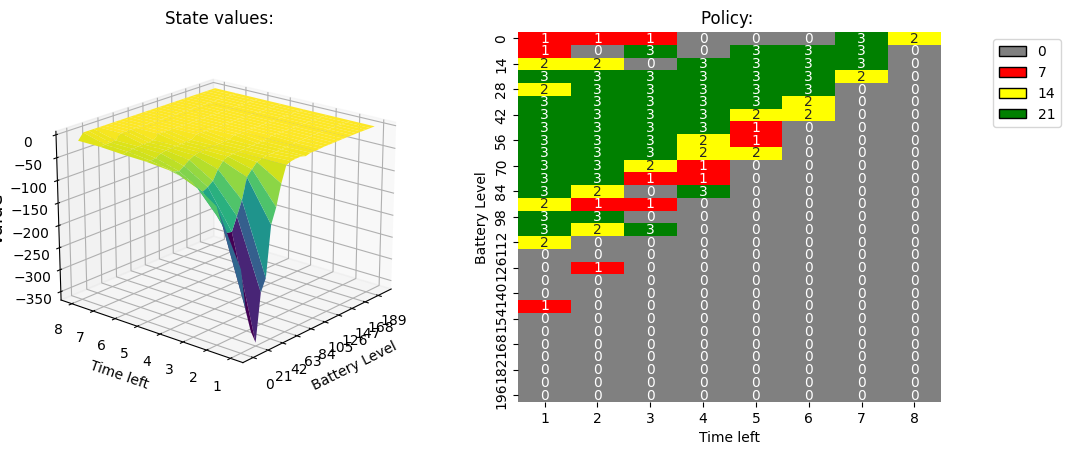

In [9]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(sarsa_agent.q_values)
fig1 = create_plots(value_grid, policy_grid)
plt.show()

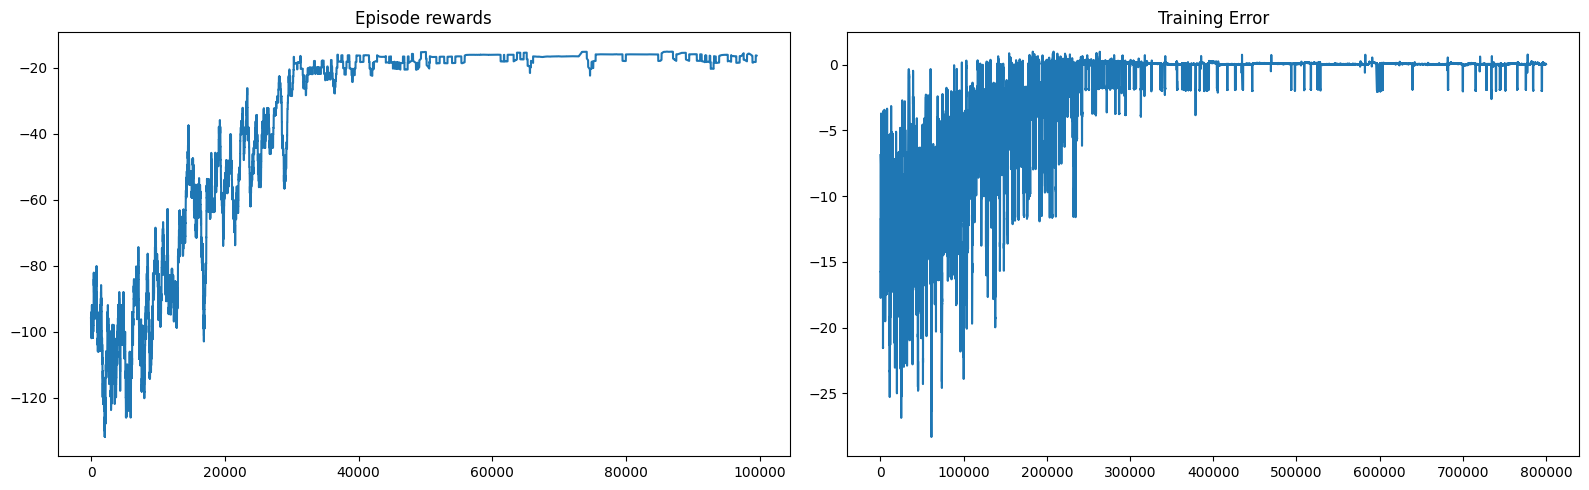

In [10]:
plot_training_performance(env, sarsa_agent)

In [11]:
env.close()

## Second RL-model: Q-learning (TD control problem, Off-Policy)

### Questions

Charging cost kinda stupid????
Where should p lie, between 0 and? else the valie gets way to high. And why the sum if we calculate it after every step?

In [12]:
class QAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, observation: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[observation]))

    def update(
        self,
        observation: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_observation: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_observation])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[observation][action]
        )

        self.q_values[observation][action] = (
            self.q_values[observation][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [13]:
def run_q_learning(env, q_agent, **kwargs):
    for episode in tqdm.tqdm(range(n_episodes)):
        observation, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = q_agent.get_action(observation)
            next_observation, reward, terminated, truncated, info = env.step(action)

            # update the agent
            q_agent.update(observation, action, reward, terminated, next_observation)

            # update if the environment is done and the current observation
            done = terminated or truncated
            observation = next_observation

        q_agent.decay_epsilon()

In [14]:
# hyperparameters
learning_rate = 0.01
start_epsilon = 1.0
n_episodes = 100000
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

env = SmartChargingEnv()
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

q_agent = QAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

run_q_learning(env, q_agent)

/home/max/Project_AAA/.venv/lib/python3.10/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(
  0%|          | 174/100000 [00:00<00:57, 1733.31it/s]

100%|██████████| 100000/100000 [00:54<00:00, 1845.54it/s]


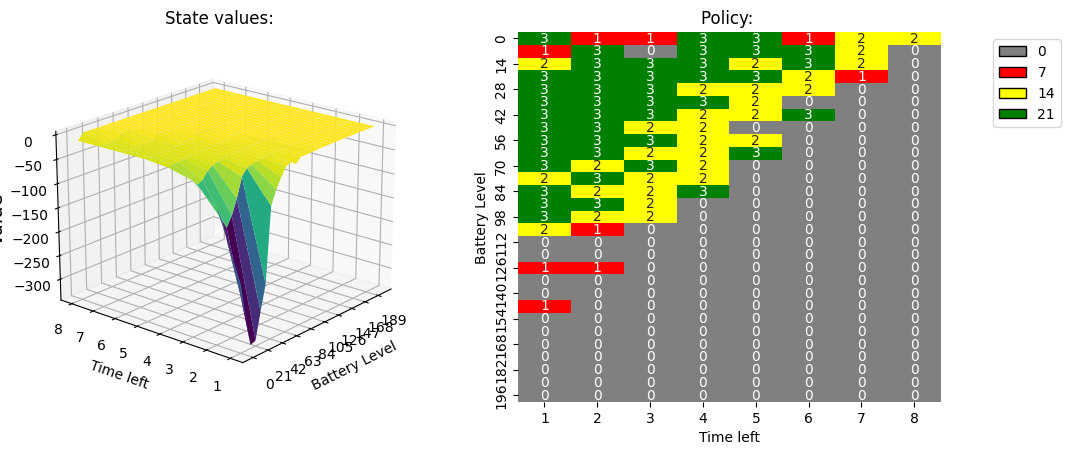

In [15]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(q_agent.q_values)
fig1 = create_plots(value_grid, policy_grid)
plt.show()

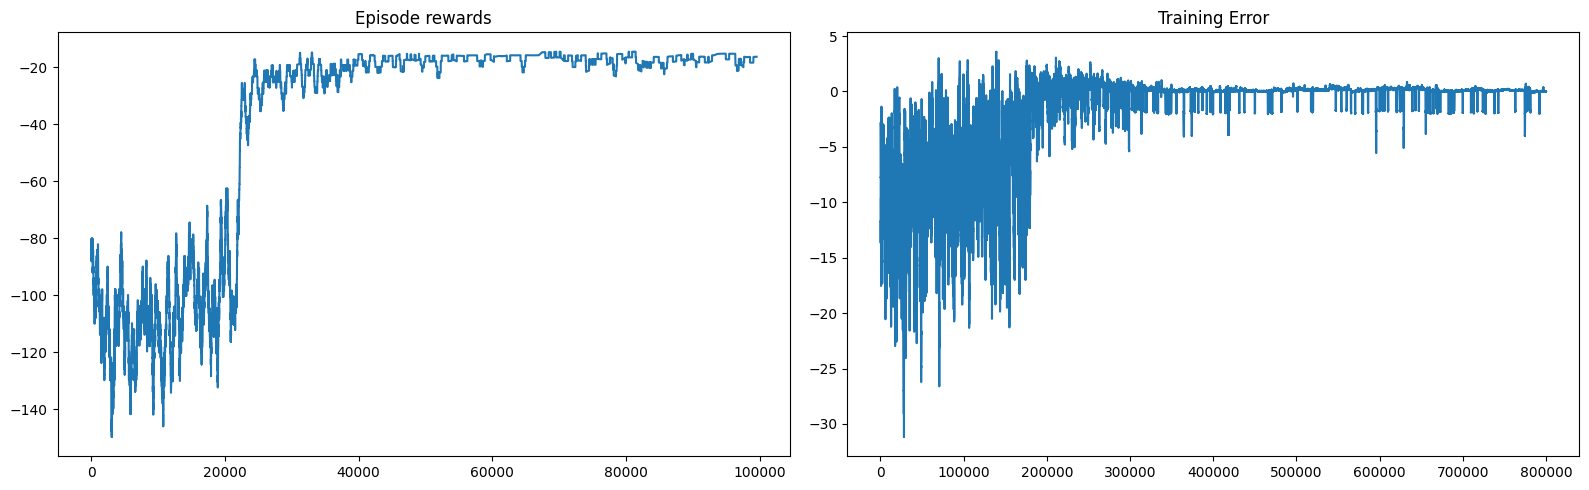

In [16]:
plot_training_performance(env, q_agent)

In [17]:
env.close()

## (Second RL-model advanced: Double Q-learning)

In [22]:
class DoubleQAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        q_values_a = defaultdict(lambda: np.zeros(env.action_space.n))
        q_values_b = defaultdict(lambda: np.zeros(env.action_space.n))
        self.q_values = [q_values_a, q_values_b]

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, observation: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax((self.q_values[0][observation] + self.q_values[1][observation]) / 2))

    def update(
        self,
        observation: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_observation: tuple[int, int, bool],
    ):
        # chose which q_value to update at random
        q_value_flag = round(np.random.random())
        
        """Updates the Q-value of an action."""
        future_action = (not terminated) * np.argmax(self.q_values[q_value_flag][next_observation])
        temporal_difference = (
            reward + self.discount_factor * self.q_values[q_value_flag - 1][next_observation][future_action] - self.q_values[q_value_flag][observation][action])
        
        self.q_values[q_value_flag][observation][action] = (
            self.q_values[q_value_flag][observation][action] + self.lr * temporal_difference)
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [23]:
# hyperparameters
learning_rate = 0.01
start_epsilon = 1.0
n_episodes = 100000
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

env = SmartChargingEnv()
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

doubleq_agent = DoubleQAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

run_q_learning(env, doubleq_agent)

/home/max/Project_AAA/.venv/lib/python3.10/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(
  0%|          | 0/100000 [00:00<?, ?it/s]


TypeError: list indices must be integers or slices, not numpy.float64

In [ ]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(doubleq_agent.q_values[0])
fig1 = create_plots(value_grid, policy_grid)
plt.show()

# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(doubleq_agent.q_values[1])
fig1 = create_plots(value_grid, policy_grid)
plt.show()

In [ ]:
plot_training_performance(env, doubleq_agent)

In [ ]:
env.close()

## Third RL-model: Deep Q-learning
Build this in Google Colab with GPU environment selected

In [ ]:
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam


class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions, discrete=False):
        self.mem_size = max_size
        self.memory_counter = 0
        self.discrete = discrete
        self.state_memory = np.zeros((self.mem_size, input_shape))
        self.new_state_memory = np.zeros((self.mem_size, input_shape))
        dtype = np.int8 if self.discrete else np.float32
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.memory_counter % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        # store one hot encoding of actions, if appropriate
        if self.discrete:
            actions = np.zeros(self.action_memory.shape[1])
            actions[action] = 1.0
            self.action_memory[index] = actions
        else:
            self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - done
        self.memory_counter += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.memory_counter, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

def build_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims):
    model = Sequential([
                Dense(fc1_dims, input_shape=(input_dims,)),
                Activation('relu'),
                Dense(fc2_dims),
                Activation('relu'),
                Dense(n_actions)])

    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

    return model

2023-08-13 13:24:46.097710: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-13 13:24:46.490676: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-13 13:24:46.492707: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-13 13:24:47.817439: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
class DeepQAgent(object):
    def __init__(self, alpha, gamma, n_actions, epsilon, batch_size,
                 input_dims, epsilon_dec=0.996,  epsilon_end=0.01,
                 mem_size=10000, fname='dqn_model.h5'):
        self.action_space = [i for i in range(n_actions)]
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_end
        self.batch_size = batch_size
        self.model_file = fname
        self.memory = ReplayBuffer(mem_size, input_dims, n_actions,
                                   discrete=True)
        self.q_eval = build_dqn(alpha, n_actions, input_dims, 256, 256)

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)
        
    def get_action(self, state):
        state = np.asarray(state)
        state = state[np.newaxis, :]
        rand = np.random.random()
        if rand < self.epsilon:
            return env.action_space.sample()
        else:
            actions = self.q_eval.predict(state, verbose = 0)
            action = np.argmax(actions)

        return action

    def learn(self):
        if self.memory.memory_counter > self.batch_size:
            state, action, reward, new_state, done = \
                                          self.memory.sample_buffer(self.batch_size)

            action_values = np.array(self.action_space, dtype=np.int8)
            action_indices = np.dot(action, action_values)

            q_eval = self.q_eval.predict(state, verbose = 0)

            q_next = self.q_eval.predict(new_state, verbose = 0)

            q_target = q_eval.copy()

            batch_index = np.arange(self.batch_size, dtype=np.int32)

            q_target[batch_index, action_indices] = reward + \
                                  self.gamma*np.max(q_next, axis=1)*done

            _ = self.q_eval.fit(state, q_target, verbose=0)

            self.epsilon = self.epsilon*self.epsilon_dec if self.epsilon > \
                           self.epsilon_min else self.epsilon_min

    def save_model(self):
        self.q_eval.save(self.model_file)

    def load_model(self):
        self.q_eval = load_model(self.model_file)

In [ ]:
# Utilities
def plotLearning(x, scores, epsilons, filename, lines=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    #ax2.xaxis.tick_top()
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    #ax2.set_xlabel('x label 2', color="C1")
    ax2.set_ylabel('Score', color="C1")
    #ax2.xaxis.set_label_position('top')
    ax2.yaxis.set_label_position('right')
    #ax2.tick_params(axis='x', colors="C1")
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)

2023-08-13 13:24:49.739187: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-13 13:24:49.740021: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
 10%|█         | 10/100 [00:05<01:20,  1.11it/s]/home/max/Project_AAA/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


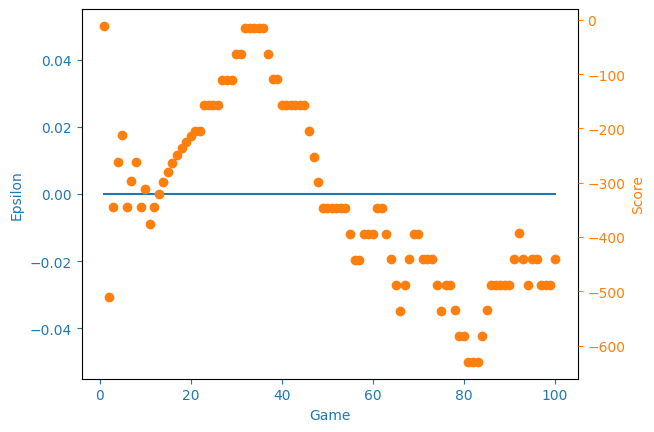

In [ ]:
env = SmartChargingEnv()
lr = 0.0005
n_games = 100
deepq_agent = DeepQAgent(gamma=0.99, epsilon=0.0, alpha=lr, input_dims=2,
                n_actions=4, mem_size=1000000, batch_size=64, epsilon_end=0.0)

# deepq_agent.load_model()
scores = []
eps_history = []

for i in tqdm.tqdm(range(n_games)):
    done = False
    score = 0
    observation = env.reset()[0]
    while not done:
        action = deepq_agent.get_action(observation)
        observation_, reward, done, info, ff = env.step(action)
        score += reward
        deepq_agent.remember(observation, action, reward, observation_, int(done))
        observation = observation_
        deepq_agent.learn()

    eps_history.append(deepq_agent.epsilon)
    scores.append(score)

    avg_score = np.mean(scores[max(0, i-100):(i+1)])
    # print('episode: ', i,'score: %.2f' % score,
    #        ' average score %.2f' % avg_score)

    if i % 10 == 0 and i > 0:
        deepq_agent.save_model()

filename = 'deepqlearning.png'

x = [i+1 for i in range(n_games)]
plotLearning(x, scores, eps_history, filename)